In [1]:
#importamos librerias necesarias para la manipulación
import pandas as pd
import numpy as np

In [2]:
# Prerequisite: Installs the latest version of Ludwig in the Colab environment
%pip ludwig[llm]
%pip install ludwig[viz]

ERROR: unknown command "ludwig[llm]"
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 63.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.8/80.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 16.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [3]:
#Cargamos base de datos en formato CSV
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df=pd.read_csv('/content/drive/MyDrive/negativa_positiva - Hoja 1.csv')

In [5]:
df

,TITULO,DESCRIPCION,CATEGORIA,DUMMY
0,¡Preocupante! Ocupación hotelera en Colombia s...,De acuerdo con el Sistema de Información Hotel...,NEGATIVA,-1
1,Dumek: “No puedo decir que a Cartagena la saqu...,"Dumek Turbay, que resultó siendo el gran vence...",NEGATIVA,-1
2,Reportan baja de operaciones en 4 de las 10 ru...,"De enero a septiembre de este año, cuatro de l...",NEGATIVA,-1
3,BM advierte que pagos de la deuda privan de di...,"Brasil, Argentina, México, Colombia y Ecuador ...",NEGATIVA,-1
4,La Cumbre del Clima podría promover la expansi...,El documento final de la COP28 en Dubái da pie...,NEGATIVA,-1
...,...,...,...,...
410,Los costos están impulsando cambios en los háb...,El turismo en Colombia está en alza a nivel in...,POSITIVA,1
411,La nueva aerolínea que solicitó operar en Colo...,"\r\nUna nueva aerolínea, ALMA, solicita operar...",POSITIVA,1
412,Nuestra meta es llegar a todos los rincones tu...,"Civitatis, plataforma de actividades turística...",POSITIVA,1
413,Dan detalles del plan para reactivar la econom...,El presidente Gustavo Petro anunció la prepara...,POSITIVA,1


In [6]:
# Para contar cuántas veces aparece cada valor en la columna CATEGORIA
conteo = df['CATEGORIA'].value_counts()

print(conteo)

CATEGORIA
POSITIVA    271
NEGATIVA    144
Name: count, dtype: int64


In [7]:
from sklearn.model_selection import train_test_split

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [8]:
# Guardar los conjuntos de datos
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

In [20]:
#Token Hugging face acceso
import getpass
#import locale; locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
import logging
import os

#from ludwig.api import LudwigModel


os.environ["HUGGING_FACE_HUB_TOKEN"] = getpass.getpass("Token:")
assert os.environ["HUGGING_FACE_HUB_TOKEN"]

Token:··········


In [21]:
from torchtext.transforms import SentencePieceTokenizer

In [ ]:
import logging
from ludwig.api import LudwigModel
# Configuración ajustada
config = {
    "input_features": [
        {
            "name": "DESCRIPCION ",
            "type": "text",
            "preprocessing": {"tokenizer":"hf_tokenizer"},
            "encoder": {
                "type": "auto_transformer",
                "pretrained_model_name_or_path": "dccuchile/bert-base-spanish-wwm-uncased",
                "trainable": True,
                "regularizer": {
                    "type": "l2",
                    "weight": 0.001,
                    # Regularización L2 aplicada al encoder
                }
            }
        },
    ],
    "output_features": [
        {
            "name": "CATEGORIA",
            "type": "binary",
            "calibration": True
        }
    ],
    "preprocessing": {
        "oversample_minority": 0.5
      },
    "adapter": {  # Corregido el espacio adicional en el nombre de la clave
        "type": "lora",
        "r": 8,
        "dropout": 0.05,
        "target_modules": None,  # Corregido de Null a None
        "use_rslora": False,
        "use_dora": False,
        "alpha": 16,
        "pretrained_adapter_weights": None,  # Corregido de Null a None
        "postprocessor": {
            "merge_adapter_into_base_model": False,
            "progressbar": False,
            "bias_type": "none"  # Corregido para que el valor sea una cadena
        }
    },
    "trainer": {
        "epochs": 40,
        "learning_rate": 0.00005,
        "optimizer": {"type": "adamw"},
        "batch_size": 20,
    }
}

In [ ]:
# Crea una instancia del modelo Ludwig con la configuración
model = LudwigModel(config, logging_level=logging.INFO)

In [24]:
train_stats,pred,out = model.train(dataset=train_df)

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run_0                                                   │
├──────────────────┼─────────────────────────────────────────────────────────────────

Training:   2%|▎         | 12/480 [00:08<05:11,  1.50it/s, loss=3.91]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 12, epoch: 1


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.2214s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤══════════╤══════════════╤═════════╕
│               │    train │   validation │    test │
╞═══════════════╪══════════╪══════════════╪═════════╡
│ accuracy      │   0.5758 │       0.3030 │  0.2879 │
├───────────────┼──────────┼──────────────┼─────────┤
│ loss          │ 156.3181 │      87.7508 │ 73.0788 │
├───────────────┼──────────┼──────────────┼─────────┤
│ precision     │   0.3895 │       0.3030 │  0.2879 │
├───────────────┼──────────┼──────────────┼─────────┤
│ recall        │   0.4805 │       1.0000 │  1.0000 │
├───────────────┼──────────┼──────────────┼─────────┤
│ roc_auc       │   0.5369 │       0.5000 │  0.5000 │
├───────────────┼──────────┼──────────────┼─────────┤
│ specificity   │   0.6234 │       0.0000 │  0.0000 │
├───────────────┼──────────┼──────────────┼─────────┤
│ combined_loss │ 156.3181 │      87.7508 │ 73.0788 │
╘═══════════════╧══════════╧══════════════


Training:   5%|▌         | 24/480 [00:41<06:17,  1.21it/s, loss=9.29]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 24, epoch: 2


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  3.74it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.2497s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.4589 │       0.3030 │  0.2879 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │ 62.5120 │      39.7741 │ 33.4751 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.2966 │       0.3030 │  0.2879 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.4545 │       1.0000 │  1.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.4610 │       0.5217 │  0.5106 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.4610 │       0.0000 │  0.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │ 62.5120 │      39.7741 │ 33.4751 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:   8%|▊         | 36/480 [01:30<06:48,  1.09it/s, loss=2.99]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 36, epoch: 3


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.2266s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.5325 │       0.3636 │  0.3636 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │ 29.7453 │      12.4710 │ 17.9281 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.3578 │       0.3103 │  0.3115 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.5065 │       0.9000 │  1.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.5298 │       0.6196 │  0.5689 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.5455 │       0.1304 │  0.1064 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │ 29.7453 │      12.4710 │ 17.9281 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  10%|█         | 48/480 [02:25<06:51,  1.05it/s, loss=2.83]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 48, epoch: 4


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.2257s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │   validation │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  0.5801 │       0.5152 │ 0.4697 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │ 19.7410 │       3.9523 │ 7.6866 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.3980 │       0.3750 │ 0.3519 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.5065 │       0.9000 │ 1.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.5616 │       0.7130 │ 0.7940 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  0.6169 │       0.3478 │ 0.2553 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │ 19.7410 │       3.9523 │ 7.6866 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  12%|█▎        | 60/480 [03:06<06:04,  1.15it/s, loss=0.000338]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 60, epoch: 5


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  3.72it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.2409s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │   validation │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  0.5974 │       0.8485 │ 0.8939 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │ 15.5299 │       9.3233 │ 4.0734 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.4231 │       0.8571 │ 0.9286 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.5714 │       0.6000 │ 0.6842 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.6510 │       0.8304 │ 0.9513 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  0.6104 │       0.9565 │ 0.9787 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │ 15.5299 │       9.3233 │ 4.0734 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  15%|█▌        | 72/480 [04:34<07:41,  1.13s/it, loss=18.4]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 72, epoch: 6


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.2267s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │   validation │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  0.8182 │       0.8788 │ 0.8788 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │ 12.2874 │       4.5459 │ 3.4737 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.7215 │       1.0000 │ 1.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.7403 │       0.6000 │ 0.5789 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.8645 │       0.8696 │ 0.9546 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  0.8571 │       1.0000 │ 1.0000 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │ 12.2874 │       4.5459 │ 3.4737 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  18%|█▊        | 84/480 [05:56<07:10,  1.09s/it, loss=1.29e-23]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 84, epoch: 7


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.2431s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤════════╕
│               │   train │   validation │   test │
╞═══════════════╪═════════╪══════════════╪════════╡
│ accuracy      │  0.8831 │       0.8485 │ 0.9091 │
├───────────────┼─────────┼──────────────┼────────┤
│ loss          │  3.6276 │       2.5468 │ 1.4107 │
├───────────────┼─────────┼──────────────┼────────┤
│ precision     │  0.8676 │       0.7778 │ 0.8824 │
├───────────────┼─────────┼──────────────┼────────┤
│ recall        │  0.7662 │       0.7000 │ 0.7895 │
├───────────────┼─────────┼──────────────┼────────┤
│ roc_auc       │  0.9446 │       0.8674 │ 0.9692 │
├───────────────┼─────────┼──────────────┼────────┤
│ specificity   │  0.9416 │       0.9130 │ 0.9574 │
├───────────────┼─────────┼──────────────┼────────┤
│ combined_loss │  3.6276 │       2.5468 │ 1.4107 │
╘═══════════════╧═════════╧══════════════╧════════╛
INFO:ludwig.trainers.t


Training:  20%|██        | 96/480 [06:55<06:04,  1.05it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 96, epoch: 8


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.2247s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9351 │       0.8788 │  0.8939 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  1.4584 │      17.4845 │ 17.5252 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.8523 │       0.8750 │  1.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9740 │       0.7000 │  0.6316 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9761 │       0.8261 │  0.8903 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9156 │       0.9565 │  1.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  1.4584 │      17.4845 │ 17.5252 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  22%|██▎       | 108/480 [07:35<05:10,  1.20it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 108, epoch: 9


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  3.68it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.2523s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9827 │       0.8182 │  0.9091 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  1.6117 │       6.6334 │ 10.0983 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9740 │       0.6667 │  0.7826 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9740 │       0.8000 │  0.9474 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9864 │       0.8891 │  0.9378 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9870 │       0.8261 │  0.8936 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  1.6117 │       6.6334 │ 10.0983 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  25%|██▌       | 120/480 [09:12<07:00,  1.17s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 120, epoch: 10


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  3.75it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.2700s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9481 │       0.9394 │  0.9091 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  1.1474 │       3.4808 │ 16.6934 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9452 │       0.9000 │  0.8421 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.8961 │       0.9000 │  0.8421 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9855 │       0.9239 │  0.9138 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9740 │       0.9565 │  0.9362 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  1.1474 │       3.4808 │ 16.6934 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  28%|██▊       | 132/480 [10:30<06:15,  1.08s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 132, epoch: 11


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  3.74it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.2508s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.7186 │       0.8788 │  0.9242 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │ 65.9309 │      56.5487 │ 41.2449 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.5492 │       0.8750 │  0.8889 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.8701 │       0.7000 │  0.8421 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.7648 │       0.8283 │  0.8998 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.6429 │       0.9565 │  0.9574 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │ 65.9309 │      56.5487 │ 41.2449 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  30%|███       | 144/480 [11:12<04:42,  1.19it/s, loss=1.29]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 144, epoch: 12


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  3.78it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.2448s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9870 │       0.8485 │  0.9091 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  4.1917 │      77.7776 │ 53.7362 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9868 │       0.8571 │  0.9333 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9740 │       0.6000 │  0.7368 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9966 │       0.7783 │  0.8550 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9935 │       0.9565 │  0.9787 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  4.1917 │      77.7776 │ 53.7362 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  32%|███▎      | 156/480 [12:09<05:01,  1.07it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 156, epoch: 13


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  3.75it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.2254s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9827 │       0.8485 │  0.9091 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  7.9671 │      35.1195 │ 23.8596 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9740 │       0.7273 │  0.8421 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9740 │       0.8000 │  0.8421 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9863 │       0.8304 │  0.8891 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9870 │       0.8696 │  0.9362 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  7.9671 │      35.1195 │ 23.8596 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  35%|███▌      | 168/480 [12:38<03:57,  1.31it/s, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 168, epoch: 14


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  3.76it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.2401s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9913 │       0.7879 │  0.8333 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  1.2967 │      47.3397 │ 83.8483 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9870 │       0.6364 │  0.6667 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9870 │       0.7000 │  0.8421 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9967 │       0.7630 │  0.8449 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9935 │       0.8261 │  0.8298 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  1.2967 │      47.3397 │ 83.8483 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Training:  38%|███▊      | 180/480 [14:03<05:25,  1.09s/it, loss=0]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 180, epoch: 15


Evaluation test : 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1.2235s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════╤═════════╤══════════════╤═════════╕
│               │   train │   validation │    test │
╞═══════════════╪═════════╪══════════════╪═════════╡
│ accuracy      │  0.9827 │       0.8182 │  0.8485 │
├───────────────┼─────────┼──────────────┼─────────┤
│ loss          │  7.5421 │      54.3664 │ 47.4999 │
├───────────────┼─────────┼──────────────┼─────────┤
│ precision     │  0.9620 │       1.0000 │  1.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ recall        │  0.9870 │       0.4000 │  0.4737 │
├───────────────┼─────────┼──────────────┼─────────┤
│ roc_auc       │  0.9838 │       0.7870 │  0.7850 │
├───────────────┼─────────┼──────────────┼─────────┤
│ specificity   │  0.9805 │       1.0000 │  1.0000 │
├───────────────┼─────────┼──────────────┼─────────┤
│ combined_loss │  7.5421 │      54.3664 │ 47.4999 │
╘═══════════════╧═════════╧══════════════╧═════════╛
INFO:


Evaluation valid: 100%|██████████| 2/2 [00:00<00:00,  4.38it/s]

INFO:ludwig.utils.calibration:Before temperature scaling:
    Negative log-likelihood: 6.751
    Expected Calibration Error: 0.061
INFO:ludwig.utils.calibration:Optimal temperature: 25.049
INFO:ludwig.utils.calibration:After temperature scaling:
    Negative log-likelihood: 0.297
    Expected Calibration Error: 0.080


INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒═════════════════╕
INFO:ludwig.utils.print_utils:│ TRAINING REPORT │
INFO:ludwig.utils.print_utils:╘═════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒═════════════════════════════════╤════════════════════╕
│ Validation feature              │ CATEGORIA          │
├─────────────────────────────────┼────────────────────┤
│ Validation metric               │ roc_auc            │
├─────────────────────────────────┼────────────────────┤
│ Best model step                 │ 120                │
├─────────────────────────────────┼────────────────────┤
│ Best model epoch                │ 11                 │
├─────────────────────────────────┼────────────────────┤
│ Best model's validation roc_auc │ 0.9239131212234497 │
├─────────────────────────────────┼────────────────────┤
│ Best model's test roc_auc       │ 0.9137737154960632 │
╘═════════════════════════════════╧════════════════════╛
INFO:ludwig.api:
Finished: api_

In [25]:
#Evaluación modelo
test_stats, predictions, output_directory = model.evaluate(
  test_df,
  collect_predictions=True,
  collect_overall_stats=True
)

HF output: [4, 1044, 1004, 10390, 30982, 30963, 1019, 18125, 8930, 5]
TT output: [4, 1044, 1004, 1492, 30963, 1019, 18125, 8930, 5]
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of dccuchile/bert-base-spanish-wwm-uncased tokenizer


Evaluation: 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]

INFO:ludwig.models.predictor:
===== CATEGORIA =====
INFO:ludwig.models.predictor:accuracy: 0.891566276550293
INFO:ludwig.models.predictor:average_precision_macro: 0.8564921514425412
INFO:ludwig.models.predictor:average_precision_micro: 0.8564921514425412
INFO:ludwig.models.predictor:average_precision_samples: 0.8564921514425412
INFO:ludwig.models.predictor:loss: 19.337995529174805
INFO:ludwig.models.predictor:overall_stats: { 'avg_f1_score_macro': 0.8883908561183326,
  'avg_f1_score_micro': 0.891566265060241,
  'avg_f1_score_weighted': 0.8908858202869749,
  'avg_precision_macro': 0.8945454545454545,
  'avg_precision_micro': 0.891566265060241,
  'avg_precision_weighted': 0.891566265060241,
  'avg_recall_macro': 0.8847517730496455,
  'avg_recall_micro': 0.891566265060241,
  'avg_recall_weighted': 0.891566265060241,
  'kappa_score': 0.7770814682184423,
  'token_accuracy': 0.891566265060241}
INFO:ludwig.models.predictor:per_class_stats: {False: {   'accuracy': 0.891566265060241,
    'f1_sc

/usr/local/lib/python3.10/dist-packages/ludwig/utils/visualization_utils.py:1179: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([""] + labels, rotation=45, ha="left")
/usr/local/lib/python3.10/dist-packages/ludwig/utils/visualization_utils.py:1180: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([""] + labels, rotation=45, ha="right")


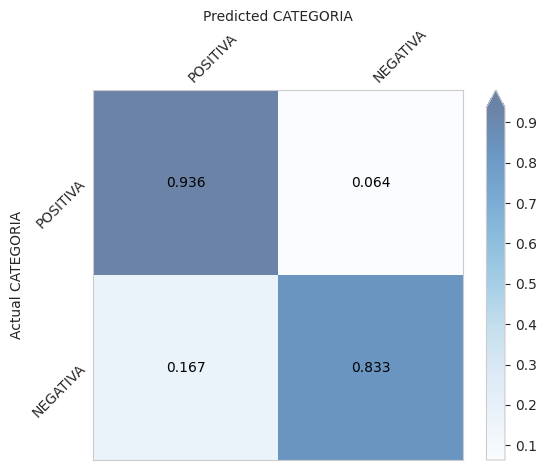

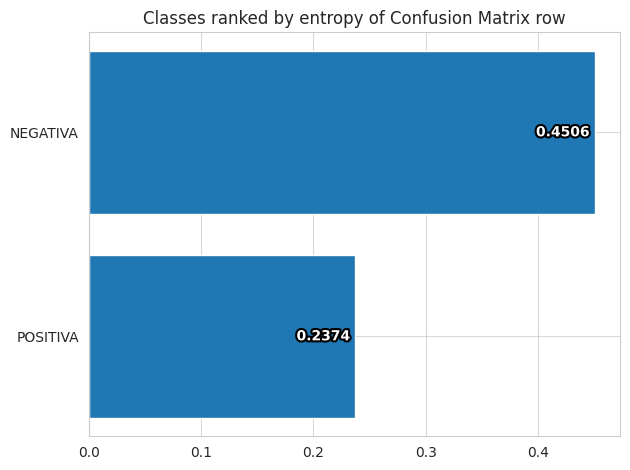

In [26]:
# Visualizes confusion matrix, which gives an overview of classifier performance
# for each class.
from ludwig.visualize import confusion_matrix

confusion_matrix(
  [test_stats],
  model.training_set_metadata,
  'CATEGORIA',
  top_n_classes=[5],
  model_names=['BertEspañolLora_Turismo'],
  normalize=True,
)

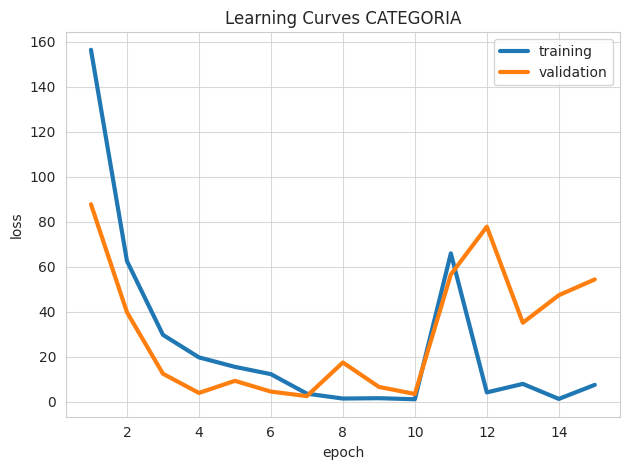

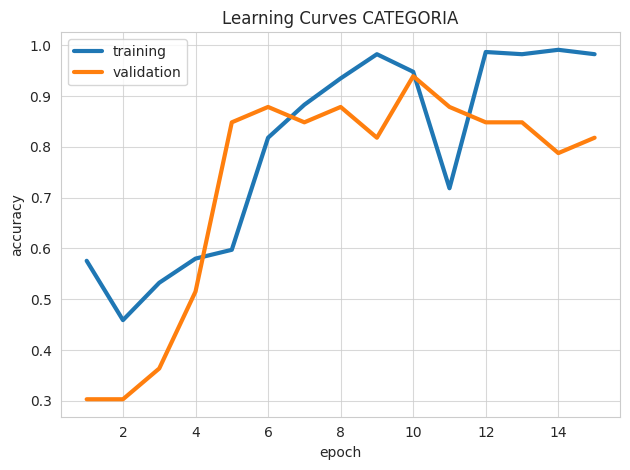

In [27]:
# Visualizes learning curves, which show how performance metrics changed over
# time during training.
from ludwig.visualize import learning_curves

learning_curves(train_stats, output_feature_name='CATEGORIA')

In [28]:
import pandas as pd

# Crear un DataFrame con las descripciones de noticias de turismo
text_to_predict = pd.DataFrame({
    "DESCRIPCION ": [
        "Cartagena celebra un incremento del 20% en turismo gracias a sus festivales de música y arte, impulsando la economía local.",
        "El nuevo parque temático en Medellín atrae a familias de todo el país, marcando un hito en el turismo de aventura urbana.",
        "Colombia es nombrada el mejor destino turístico de Sudamérica por su rica cultura y hospitalidad.",
        "El festival de la flores en Medellín se supera en asistencia, con un aumento del 30% en turistas internacionales.",
        "Escándalo por malas prácticas en hoteles de lujo en Bogotá daña gravemente la imagen turística de la ciudad.",
        "Protestas en varias ciudades importantes afectan negativamente la temporada turística, causando una caída en las reservas.",
        "Informes de inseguridad en Cartagena disuaden a los turistas de visitar, afectando la industria hotelera local.",
        "Desastres naturales en la costa caribeña golpean la industria del turismo, con hoteles y playas cerradas durante meses.",
        "Controversia por la construcción de un nuevo aeropuerto en Barranquilla amenaza zonas ecológicas y despierta críticas de grupos ambientalistas."
    ]
})

# Utilizar el DataFrame para hacer predicciones
predictions, output_directory = model.predict(text_to_predict)

# Ver las predicciones
print(predictions)

HF output: [4, 1044, 1004, 10390, 30982, 30963, 1019, 18125, 8930, 5]
TT output: [4, 1044, 1004, 1492, 30963, 1019, 18125, 8930, 5]
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of dccuchile/bert-base-spanish-wwm-uncased tokenizer


Prediction: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]

INFO:ludwig.api:Finished predicting in: 1.68s.



  CATEGORIA_probabilities CATEGORIA_predictions  \
0              [1.0, 0.0]              POSITIVA   
1              [1.0, 0.0]              POSITIVA   
2              [1.0, 0.0]              POSITIVA   
3              [1.0, 0.0]              POSITIVA   
4              [0.0, 1.0]              NEGATIVA   
5              [0.0, 1.0]              NEGATIVA   
6              [0.0, 1.0]              NEGATIVA   
7              [1.0, 0.0]              POSITIVA   
8              [0.0, 1.0]              NEGATIVA   

   CATEGORIA_probabilities_POSITIVA  CATEGORIA_probabilities_NEGATIVA  \
0                               1.0                               0.0   
1                               1.0                               0.0   
2                               1.0                               0.0   
3                               1.0                               0.0   
4                               0.0                               1.0   
5                               0.0               

In [29]:
model.save('/content/drive/MyDrive/Tesis/Collabs_finales_Experimentos_nuevoo/model')

In [ ]:
model.save_torchscript(
  '/content/drive/MyDrive/Tesis/Collabs_finales_Experimentos_nuevoo/model',device="cuda")

In [ ]:
from ludwig.models.inference import InferenceModule
inference_module=InferenceModule.from_directory('/content/drive/MyDrive/Tesis/Collabs_finales_Experimentos_nuevoo/model/')

In [42]:
raw={"DESCRIPCION ":[
    "El nuevo parque temático en Medellín atrae a familias de todo el país, marcando un hito en el turismo de aventura urbana.",

    ]
}

In [ ]:
preprocessed_data=inference_module.preprocessor_forward(raw)

In [ ]:
predictions=inference_module.predictor_forward(preprocessed_data)

In [ ]:
postprocessed_data=inference_module.postprocessor_forward(predictions)

In [ ]:
postprocessed_data

In [ ]:
!pip install gradio

In [ ]:
'la noticia es: '+ postprocessed_data['CATEGORIA']['predictions'][0]

In [ ]:
import gradio as gr

In [ ]:
def greet(Noticia):
    raw = {"DESCRIPCION ": [noticia]}
    preprocessed_data = inference_module.preprocessor_forward(raw)
    predictions = inference_module.predictor_forward(preprocessed_data)
    postprocessed_data = inference_module.postprocessor_forward(predictions)

    classification = postprocessed_data['CATEGORIA']['predictions'][0]
    return output_label + classification

In [ ]:
import gradio as gr



demo = gr.Interface(fn=greet, inputs="textbox", outputs=[gr.Textbox(label="Clasificación")], css="""
   body {background-color : pink}
    """,)



if __name__ == "__main__":
    demo.launch()